In [ ]:
import os
import warnings
import tensorflow as tf

# Suppress unnecessary warnings
warnings.simplefilter(action='ignore', category=UserWarning)
tf.get_logger().setLevel('ERROR')  # Suppresses TensorFlow warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define dataset path
data_dir = '/kaggle/input/driver-inattention-detection-dataset'

# Check dataset structure
print("Dataset files:", os.listdir(data_dir))

# Read class labels
with open(os.path.join(data_dir, 'train', '_classes.txt')) as f:
    classes = list(map(str.strip, f))

# Read image paths and labels
def load_annotations(file_path, folder):
    with open(os.path.join(data_dir, folder, file_path), 'r') as f:
        return pd.DataFrame(dict(img=os.path.join(data_dir, folder, line.split()[0]),
                                 label=classes[int(line.strip()[-1])]) for line in f if len(line.split()) > 1)

df_train = load_annotations('_annotations.txt', 'train')
df_val = load_annotations('_annotations.txt', 'valid')
df_test = load_annotations('_annotations.txt', 'test')

# Pre-processing parameters
image_unit_res = 8
img_height, img_width = 9 * image_unit_res, 16 * image_unit_res  # 16:9 preserve aspect ratio
batch_size = 32

# Convert labels to categorical
class_mapping = {class_name: i for i, class_name in enumerate(classes)}
df_train['label'] = df_train['label'].map(class_mapping).astype(str)
df_val['label'] = df_val['label'].map(class_mapping).astype(str)
df_test['label'] = df_test['label'].map(class_mapping).astype(str)

num_classes = len(classes)
train_labels = to_categorical(df_train['label'].astype(int), num_classes=num_classes)
val_labels = to_categorical(df_val['label'].astype(int), num_classes=num_classes)
test_labels = to_categorical(df_test['label'].astype(int), num_classes=num_classes)

# Data augmentation function
def add_noise(img):
    std_coeff = 50 * np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

data_gen = ImageDataGenerator(rescale=1. / 255, preprocessing_function=add_noise)

# Load images
train_data = data_gen.flow_from_dataframe(df_train, x_col='img', y_col='label',
                                          target_size=(img_height, img_width),
                                          batch_size=batch_size, class_mode='categorical',
                                          shuffle=True, color_mode='grayscale')

val_data = data_gen.flow_from_dataframe(df_val, x_col='img', y_col='label',
                                        target_size=(img_height, img_width),
                                        batch_size=batch_size, class_mode='categorical',
                                        shuffle=False, color_mode='grayscale')

test_data = data_gen.flow_from_dataframe(df_test, x_col='img', y_col='label',
                                         target_size=(img_height, img_width),
                                         batch_size=batch_size, class_mode='categorical',
                                         shuffle=False, color_mode='grayscale')

# Define input shape
input_shape = (img_height, img_width, 1)

# Load DenseNet-121 with pre-trained ImageNet weights
base_model = DenseNet121(
    weights="/kaggle/input/weights/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5",
    include_top=False, input_shape=(img_height, img_width, 3))

# Convert grayscale input to 3-channel (needed for DenseNet)
input_layer = Input(shape=input_shape)
conv_layer = Conv2D(3, (3, 3), padding='same', activation='relu')(input_layer)

# Attach base model
x = base_model(conv_layer, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)

# Define the final model
model = Model(inputs=input_layer, outputs=x)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with live updates
history = model.fit(train_data, validation_data=val_data, epochs=10, verbose=1)

# Print model summary
model.summary()

# Plot class distribution
total_counts = (df_train['label'].astype(int).value_counts()
                .add(df_val['label'].astype(int).value_counts(), fill_value=0)
                .add(df_test['label'].astype(int).value_counts(), fill_value=0)
                .sort_index())

plt.figure(figsize=(10, 6))
plt.bar(total_counts.index, total_counts.values, tick_label=[classes[i] for i in total_counts.index])
plt.xlabel("Class Labels")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in the Entire Dataset")
plt.xticks(rotation=45)
plt.show()


Dataset files: ['README.dataset.txt', 'README.roboflow.txt', 'valid', 'test', 'train']
Found 11948 validated image filenames belonging to 6 classes.
Found 1922 validated image filenames belonging to 6 classes.
Found 985 validated image filenames belonging to 6 classes.
Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 917s 2s/step - accuracy: 0.4307 - loss: 1.6600 - val_accuracy: 0.4069 - val_loss: 1.7378
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 824s 2s/step - accuracy: 0.6527 - loss: 0.9354 - val_accuracy: 0.7497 - val_loss: 0.6550
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 809s 2s/step - accuracy: 0.7399 - loss: 0.7057 - val_accuracy: 0.8174 - val_loss: 0.5172
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 810s 2s/step - accuracy: 0.7968 - loss: 0.5743 - val_accuracy: 0.8335 - val_loss: 0.4830
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 806s 2s/step - accuracy: 0.8283 - loss: 0.4800 - val_accuracy: 0.8580 - val_loss: 0.4219
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 824s 2s/step - accuracy: 0.8510 - loss: 0.426

In [ ]:
model.save("densenet121_driver_inattention.h5")


In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 482ms/step - accuracy: 0.8875 - loss: 0.3402
Test Accuracy: 0.8924
Test Loss: 0.3332


31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 602ms/step


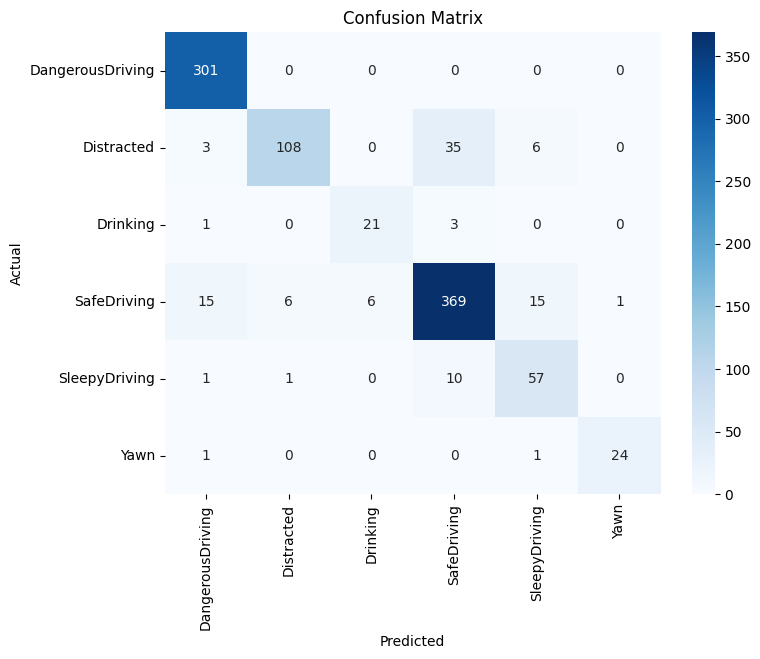

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes  # Actual class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


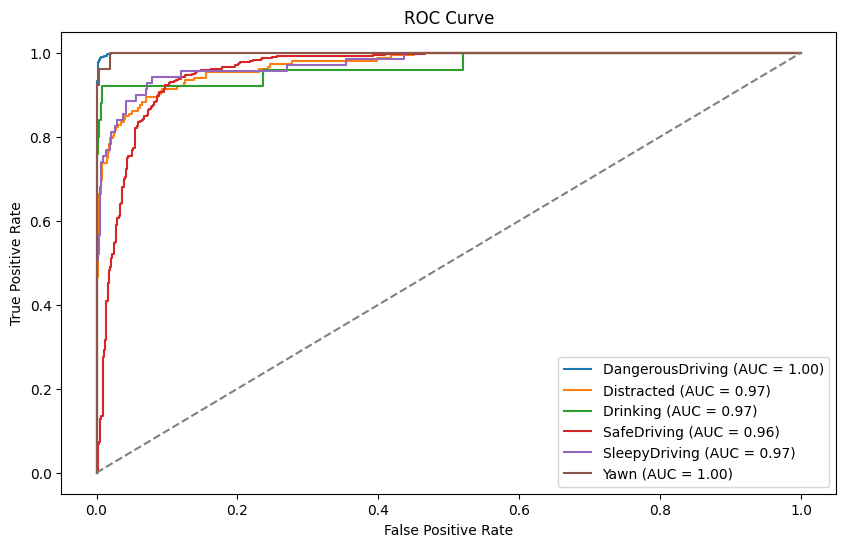

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert true labels to one-hot encoding
y_true_one_hot = label_binarize(y_true, classes=range(len(classes)))

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 6))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{classes[i]} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], linestyle="--", color="gray")  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
